In [2]:
SCITSR_PATH = '/home/longhoang01/Developer/table-recognition/data/SciTSR-partition'
MODEL_WEIGHT = '/home/longhoang01/Developer/table-recognition/pret-models/split0.pth'

In [3]:
import numpy as np
from tqdm import tqdm
import glob

from data_utils.utils import *
from merge.heuristics import *
from dataset.dataset import ImageDataset
from modules.split_modules import SplitModel

In [4]:
# LOAD MODEL
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SplitModel(3)
model = torch.nn.DataParallel(model).to(device)

if device == 'cuda':
    model.load_state_dict(torch.load(MODEL_WEIGHT))
else:
    model.load_state_dict(torch.load(MODEL_WEIGHT, map_location=torch.device('cpu')))

device

'cpu'

In [5]:
SUBSET = 'train'
print(f'Loading data for the "{SUBSET}" subset')

# Load images
img_dir = os.path.join(SCITSR_PATH, SUBSET, 'img')
img_paths = [os.path.join(img_dir, p) for p in os.listdir(img_dir)]
print(f'- Got {len(img_paths)} images')

# Load Merge labels
merge_json = os.path.join(SCITSR_PATH, SUBSET, 'label', 'merge_label.json')
merge_labels = load_json(merge_json)
print(f"- Loaded {len(merge_labels)} labels for Merge module")

# Load Text posisions
chunk_json = os.path.join(SCITSR_PATH, SUBSET, 'label', 'chunk_label.json')
chunk_labels = load_json(chunk_json)
print(f"- Loaded texts positions for {len(chunk_labels)} images")

# Load dataset
split_json = os.path.join(SCITSR_PATH, SUBSET, 'label', 'split_label.json')
split_labels = load_json(split_json)
dataset = ImageDataset(img_dir, split_labels, 8, scale=1, min_width=10, returns_image_name=True)
print(f'- Loaded dataset with {len(dataset)} examples')

Loading data for the "train" subset
- Got 10000 images
- Loaded 10000 labels for Merge module
- Loaded texts positions for 10000 images
- Loaded dataset with 10000 examples


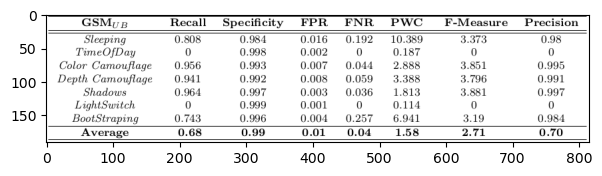

In [6]:
IDX = 0
sample_img = load_image(img_paths[IDX])
view_imgs([sample_img])

In [7]:
img_ready = prep_image(sample_img)

with torch.no_grad():
    r_pred, c_pred = model(img_ready)
r_pred, c_pred = process_split_results(r_pred, c_pred)
r_pred, c_pred = refine_split_results(r_pred), refine_split_results(c_pred)

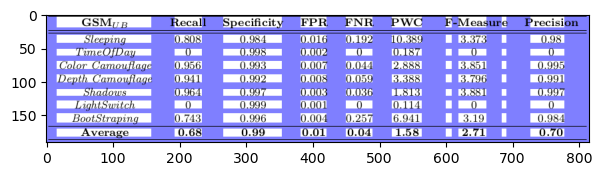

In [8]:
vis_split(sample_img, r_pred, c_pred);

In [40]:
@torch.no_grad
def get_split_results(model: SplitModel, 
                    img_dir: str, 
                    split_json: str
):
    '''
    Get split results as a dictionary for further postprocessing or analysis
    Args:
        model -- Split model
        img_dir -- string, path to image folder of on of train, val, or test set
        split_json -- string, path to json ground truth file for Split module
    Returns:
        res -- dictionary where keys are image names. 
                The value of each key is a dictionary with two keys: 'row' and 'col' which in turn
                contains 3 keys called 'prec', 'rec', and 'f1'
    '''
    # Load dataset
    split_labels = load_json(split_json)
    dataset = ImageDataset(img_dir, split_labels, 8, scale=1, min_width=10, returns_image_name=True)
    print(f'- Loaded dataset with {len(dataset)} examples')

    res = {}
    for img, label, name in tqdm(dataset):
        # ground truth
        r_gt, c_gt = label
        r_gt, c_gt = r_gt.cpu().numpy(), c_gt.cpu().numpy() 

        # prediction
        r_pred, c_pred = model(img.unsqueeze(0))
        r_pred, c_pred = process_split_results(r_pred, c_pred)
        r_pred, c_pred = refine_split_results(r_pred), refine_split_results(c_pred)

        # eval on precision, recall, and f1
        r_metrics = eval3(r_pred, r_gt)
        c_metrics = eval3(c_pred, c_gt)
        # print(r_metrics['precision'], r_metrics['recall'], r_metrics['f1'])
        # print(c_metrics['precision'], c_metrics['recall'], c_metrics['f1'])

        # log results
        res[name] = {
            'row': {
                'prec': r_metrics['precision'], 
                'rec': r_metrics['recall'], 
                'f1': r_metrics['f1']
            },
            'col': {
                'prec': c_metrics['precision'], 
                'rec': c_metrics['recall'], 
                'f1': c_metrics['f1']
            }
        }

    return res

In [39]:
train_res = get_split_results(model, img_dir, split_json)

In [41]:
SUBSET = 'val'
val_img_dir = os.path.join(SCITSR_PATH, SUBSET, 'img')
val_split_json = os.path.join(SCITSR_PATH, SUBSET, 'label', 'split_label.json')
val_res = get_split_results(model, val_img_dir, val_split_json)

- Loaded dataset with 1971 examples


100%|██████████| 1971/1971 [37:24<00:00,  1.14s/it]  


In [42]:
SAVE_PATH = '/home/longhoang01/Developer/table-recognition/results/split'

write_json(os.path.join(SAVE_PATH, f'split_output_{SUBSET}.json'), val_res)